In [1]:
# standard libraries 
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tueplots import axes, bundles , figsizes, fonts,fontsizes
import seaborn as sns
import random 
from random import randrange

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# statistics 
import statsmodels.api as sm
from scipy import stats as stat
from sklearn.inspection import partial_dependence
from sklearn.utils import resample
from scipy.stats import sem
from statsmodels.graphics.regressionplots import plot_partregress

In [3]:
# ML models
from sklearn import tree  # Classification tree        
from xgboost import XGBClassifier # xgboost 
from sklearn.ensemble import RandomForestClassifier # Random forest 

In [4]:
# ML utilities 
from imblearn.combine import SMOTEENN # data augmentation 
from sklearn.utils import shuffle
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# read in data 

In [10]:
nsw = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswLalonde_transformed.csv') # RCT
nswre74 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswDeWab_transformed.csv') # RCT 
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv') # Quasi data 
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv') # Quasi data 
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv') # Quasi data 
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv') # Quasi data 

<p> scatter plot's </p>

sns.regplot(nswCps_lalonde['black'], nswCps_lalonde['re78'], lowess=True)
plt.ylabel(' ')
plt.xlabel(' ')
plt.title(' ')
plt.show()

<p> Testing </p>

<p> end testing </p>

In [47]:
class TreeExplainer():
    """
    explainer class takes in a model, dataset, list of covariates, list of targets and feature and target to plot 
    params
    model = sklearn model (for now this only works with sci-kit learn)
    dataset = the dataset we want
    covariates = dataframe (dataframe of all of the features we are using for prediction)
    target = dataframe which contains all variables on target (treated not treated )
    """
    def __init__(self,model,dataset,model_params,covariates_string,target_string): # initialise class 
                  #bootstrap true false           
        super(TreeExplainer, self).__init__() 
        self.model = model(**model_params).fit(dataset[covariates_string],dataset[target_string]) # take the model and parameters and set it up 
        self.dataset = shuffle(dataset).reset_index(drop=True) # shuffle the dataset 
        self.features = dataset[covariates_string] # get dataframe frame of features 
        self.target = dataset[target_string]       # dataframe of targerts
        self.params = model_params

    # Partial dependency plot   
    def partial_dep_plot(self,ax,string_treat,string_covariate):
        """
        parameters
        """
        model = self.model
        covariate_values = np.linspace(np.min(self.features[string_covariate]), np.max(self.features[string_covariate])) # x-range for the feature
        pdp_values = []
        for n in covariate_values:
            X_pdp = self.features.copy()
            X_pdp[string_covariate] = n
            pdp_values.append(np.mean(self.model.predict(X_pdp)))  
        ax = ax
        ax.plot(covariate_values, pdp_values)
        ax.set_ylabel(string_treat)
        ax.set_xlabel(string_covariate)
        ax.set_title('Partial dependence plot for treated vs boosted tree')
        return ax

    # Partial dependency plot 
    def bootstrapped_partial_plot(self,ax,classifier,string_treat,string_covariate,n_bootstrap):
        # Fit standard PDP ~ ~ ~~ ~~ ~ ~~ ~ ~~ ~ ~ ~~ 
        model = self.model 
        model1 = model.fit(self.features,self.target)
        target_df = self.target
        features_df = self.features[string_covariate]

        x_values = np.linspace(np.min(features_df), np.max(features_df)) # x-range for the feature
        pdp_values = []
        for n in x_values:
            X_pdp = self.features.copy()
            X_pdp[string_covariate] = n
            pdp_values.append(np.mean(model.predict(X_pdp)))  
        ax = ax
        ax.plot(x_values, pdp_values)
        #ax.ylabel(string_treat)
        #ax.xlabel(string_covariate)
        #ax.title('Partial dependence plot for treated vs boosted tree')
        # boot strapping ~ ~ ~~ ~~ ~ ~~ ~ ~~ ~ ~ ~~ 
        n_bootstrap = n_bootstrap
        covariate_values = np.linspace(np.min(features_df), np.max(features_df))
        expected_value_bootstrap_replications = []
        features_df2 = self.features
        
        for _ in range(n_bootstrap):
            X_boot, y_boot = resample(features_df2, target_df)
            model2 = classifier(**self.params).fit(X_boot,y_boot) 
            #fitted_model = fit_data(tree.DecisionTreeClassifier,cart_hyper_params0,features_target,dataset,"none")   
            bootstrap_model_predictions = []

            for n in covariate_values:
                X_pdp = X_boot.copy()
                X_pdp[string_covariate] = n
                bootstrap_model_predictions.append(np.mean(model2.predict(X_pdp)))
            expected_value_bootstrap_replications.append(bootstrap_model_predictions)
        
        expected_value_bootstrap_replications = np.array(expected_value_bootstrap_replications)
        
        for ev in expected_value_bootstrap_replications:
            ax.plot(covariate_values, ev, color='blue', alpha=.1)

        prediction_se = np.std(expected_value_bootstrap_replications, axis=0)
        ax = ax
        ax.plot(covariate_values, pdp_values, label='Model predictions')
        ax.fill_between(covariate_values, pdp_values - 3*prediction_se, pdp_values + 3*prediction_se, alpha=.5, label='Bootstrap CI')
        #ax.legend()
        #ax.ylabel(string_treat)
        #ax.xlabel(string_covariate)
        #ax.title('Partial dependence plot for NOX vs Price for Random Forest')
        return ax 

        
    # def plotTree(ax)

<p> KEY </p>
<p> 0 = lalonde nsw rct </p>
<p> 1 = nsw treated + CPS control  (Lalonde's original sample) </p>
<p> 2 = nsw treated + PSID control (Lalonde's original sample) </p>
<p> 3 = nsw treated + CPS control  (Dehejia & Wahba sub-sample) </p>
<p> 4 = nsw treated + PSID control (Dehejia & Wahba sub-sample) </p>

# Fit all tree based models 

In [48]:

# Hyper parameters ( taken from grid search)

# For our baseline ,trained only on the RCT ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

# baseline
cart_hyper_params0 = {"random_state":0,"criterion":'entropy',"max_depth":5,"max_leaf_nodes":12,"min_samples_leaf":2} 
forest_hyper_params0 = {"random_state":0,'criterion': 'gini','max_depth': 8,'max_features': 'auto','min_samples_split': 2, 'n_estimators': 100} 
boost_hyper_params0 = {"random_state":0,"objective":"binary:logistic","seed":0, "booster":"dart", "colsample_bytree":0.3,"gamma":0.5, "learning_rate" : 0.05,"subsample":0.5, "nthread":4 }   

# CART ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

# 1 
cart_hyper_params1 = {'criterion': 'entropy','max_depth': 10,'max_leaf_nodes': 30,'min_samples_leaf': 2}

# 2
cart_hyper_params2 = {"random_state":0,"criterion":'entropy',"max_depth":5,"max_leaf_nodes":12,"min_samples_leaf":2}   

# 3
cart_hyper_params3 = {'criterion': 'entropy','max_depth': None,'max_leaf_nodes': 34,'min_samples_leaf': 2}                                          

# 4
cart_hyper_params4 = {'criterion': 'entropy','max_depth': 5,'max_leaf_nodes': 21,'min_samples_leaf': 3}                                          


#Random forest ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

# 1
forest_hyper_params1 = {"random_state":0,"criterion" : 'entropy',"max_depth":8,"max_features" :"" 'sqrt',"min_samples_split" :2,"n_estimators": 100}  
# 2
forest_hyper_params2 = {"random_state":0,'criterion': 'gini', 'max_depth': 8,'max_features': 'auto','min_samples_split': 2,'n_estimators': 100} 
# 3
forest_hyper_params3 = {"random_state":0,'criterion': 'entropy','max_depth': 8,'max_features': 'log2','min_samples_split': 3,'n_estimators': 500}
# 4
 
forest_hyper_params4 = {"random_state":0,'criterion': 'gini','max_depth': 8,'max_features': 'log2','min_samples_split': 2,'n_estimators': 500} 

# xgboost  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~

boost_hyper_params0 = {"random_state":0,"objective":"binary:logistic","seed":0, "booster":"dart", "colsample_bytree":0.3,"gamma":0.5, "learning_rate" : 0.05,"subsample":0.5, "nthread":4 }    

boost_hyper_params1 = {"random_state":0,"objective":"binary:logistic","seed":0, "booster":"dart", "colsample_bytree":0.3,"gamma":0.5, "learning_rate" : 0.05,"max_depth":None, "min_child_weight":2, "subsample":0.5, "nthread":4 }                

boost_hyper_params2 = {"random_state":0,"objective":"binary:logistic","seed":0,"booster":"dart", "colsample_bytree":0.3,"gamma":0.5, "learning_rate" : 0.05,"max_depth":None, "min_child_weight":2, "subsample":0.5, "nthread":4 }                

boost_hyper_params3 = {"random_state":0,"objective":"binary:logistic","seed":0,"booster":"dart", "colsample_bytree":0.3,"gamma":0.5, "learning_rate" : 0.05, "max_depth":None, "min_child_weight":2, "subsample":0.5, "nthread":4 }                

boost_hyper_params4 = {"random_state":0,"objective":"binary:logistic","seed":0, "booster":"dart", "colsample_bytree":0.3,"gamma":0.5, "learning_rate" : 0.05,"max_depth":None, "min_child_weight":2,"subsample":0.5, "nthread":4 }                



In [42]:
dataset_baseline_1 = nsw
dataset_baseline_2 = nswre74

# quasi experimental datasets 
dataset1 = nswCps_lalonde
dataset2 = nswPsid_lalonde
dataset3 = nswCps_dehWab
dataset4 = nswPsid_dehWab

covariates  = ['age', 'education*', 'black', 'hispanic', 'married', 'nodegree', 're75']
target = "treat"

# Plots

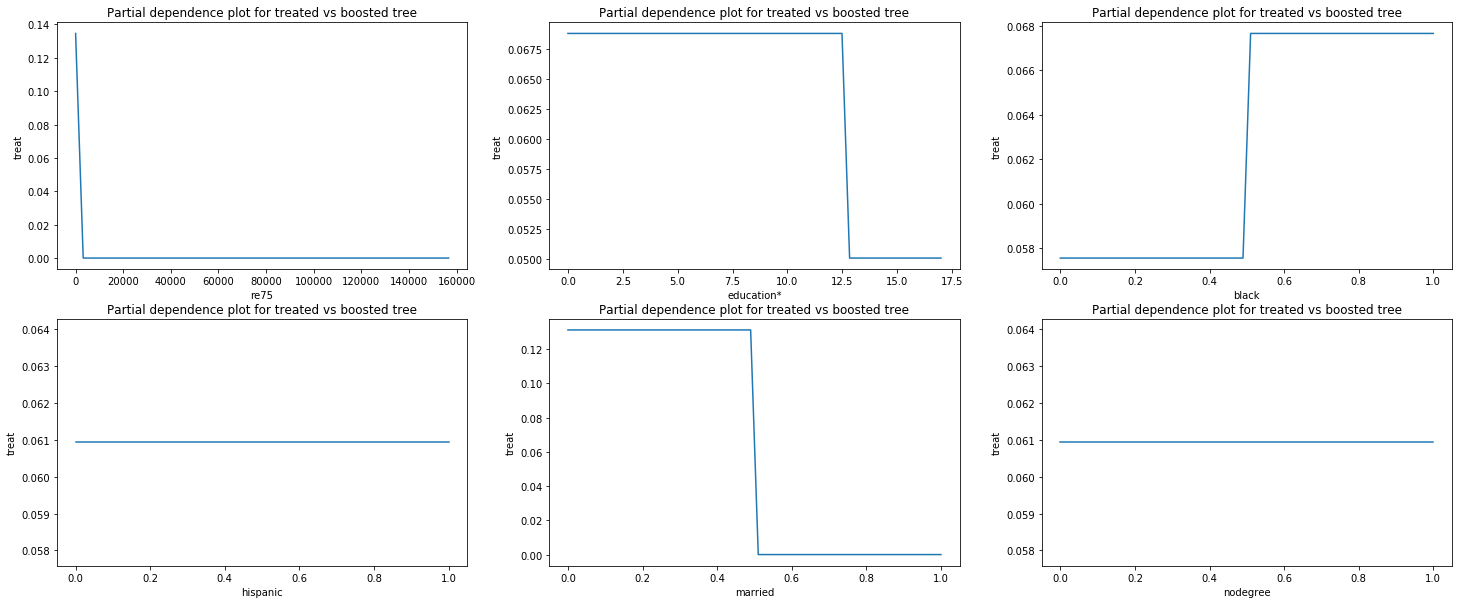

In [43]:
# CART model
cart_explainer = TreeExplainer(tree.DecisionTreeClassifier,dataset4,cart_hyper_params0,covariates,target)
# Plot forest mdoels 
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(25,10))
plot1 = cart_explainer.partial_dep_plot(ax[0,0],"treat","re75")
plot2 = cart_explainer.partial_dep_plot(ax[0,1],"treat","education*")
plot3 = cart_explainer.partial_dep_plot(ax[0,2],"treat","black")
plot4 = cart_explainer.partial_dep_plot(ax[1,0],"treat","hispanic")
plot5 = cart_explainer.partial_dep_plot(ax[1,1],"treat","married")
plot6 = cart_explainer.partial_dep_plot(ax[1,2],"treat","nodegree")
plt.show()

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


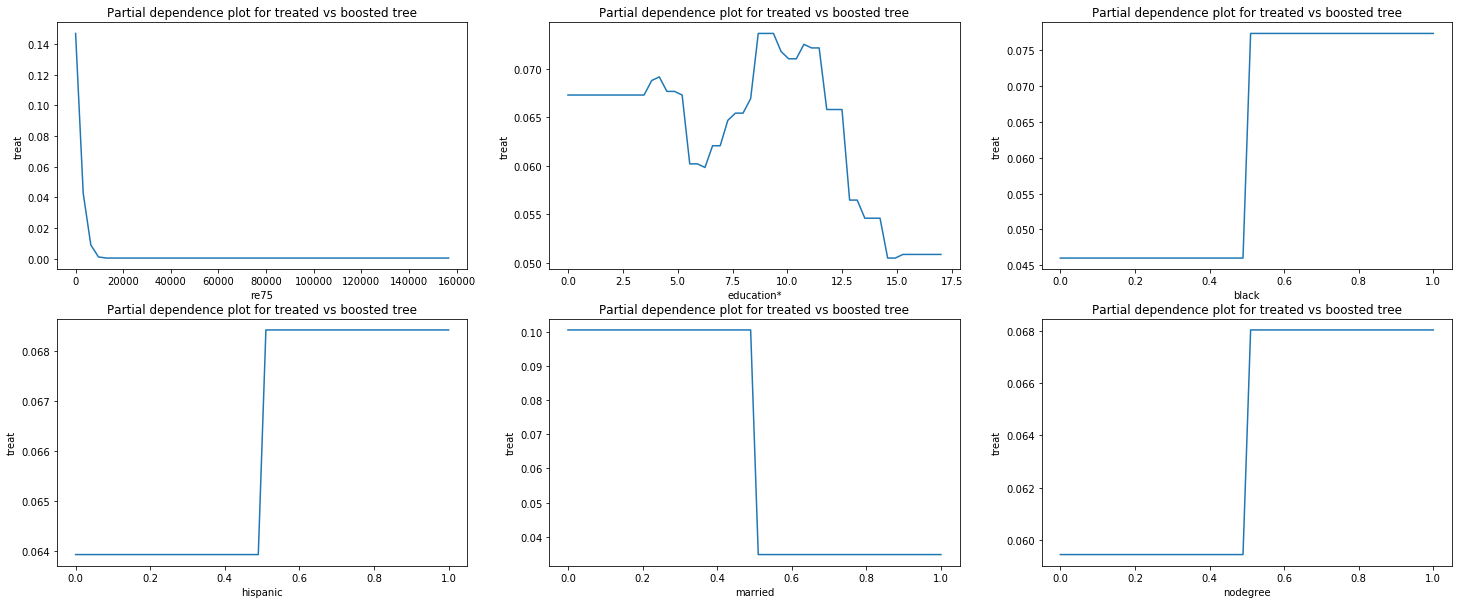

In [44]:
# Random forest model - create forest explainer obect
forest_explainer = TreeExplainer(RandomForestClassifier,dataset4,forest_hyper_params0,covariates,target)
# Plot forest mdoels 
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(25,10))
plot1 = forest_explainer.partial_dep_plot(ax[0,0],"treat","re75")
plot2 = forest_explainer.partial_dep_plot(ax[0,1],"treat","education*")
plot3 = forest_explainer.partial_dep_plot(ax[0,2],"treat","black")
plot4 = forest_explainer.partial_dep_plot(ax[1,0],"treat","hispanic")
plot5 = forest_explainer.partial_dep_plot(ax[1,1],"treat","married")
plot6 = forest_explainer.partial_dep_plot(ax[1,2],"treat","nodegree")
plt.show()

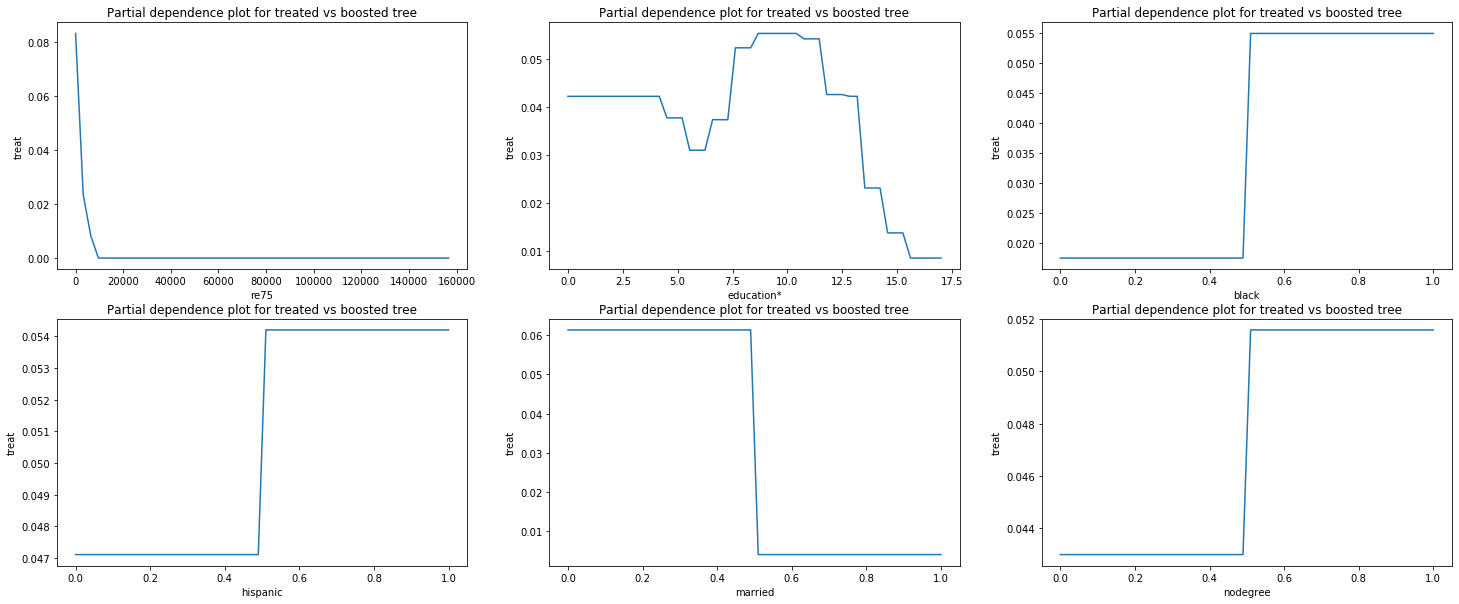

In [45]:
# XGGB - create forest explainer obect
boost_explainer = TreeExplainer(XGBClassifier,dataset4,boost_hyper_params1,covariates,target)
# Plot forest mdoels 
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(25,10))
plot1 = boost_explainer.partial_dep_plot(ax[0,0],"treat","re75")
plot2 = boost_explainer.partial_dep_plot(ax[0,1],"treat","education*")
plot3 = boost_explainer.partial_dep_plot(ax[0,2],"treat","black")
plot4 = boost_explainer.partial_dep_plot(ax[1,0],"treat","hispanic")
plot5 = boost_explainer.partial_dep_plot(ax[1,1],"treat","married")
plot6 = boost_explainer.partial_dep_plot(ax[1,2],"treat","nodegree")
plt.show()

<p> Boostrapped partial depence plots </p>

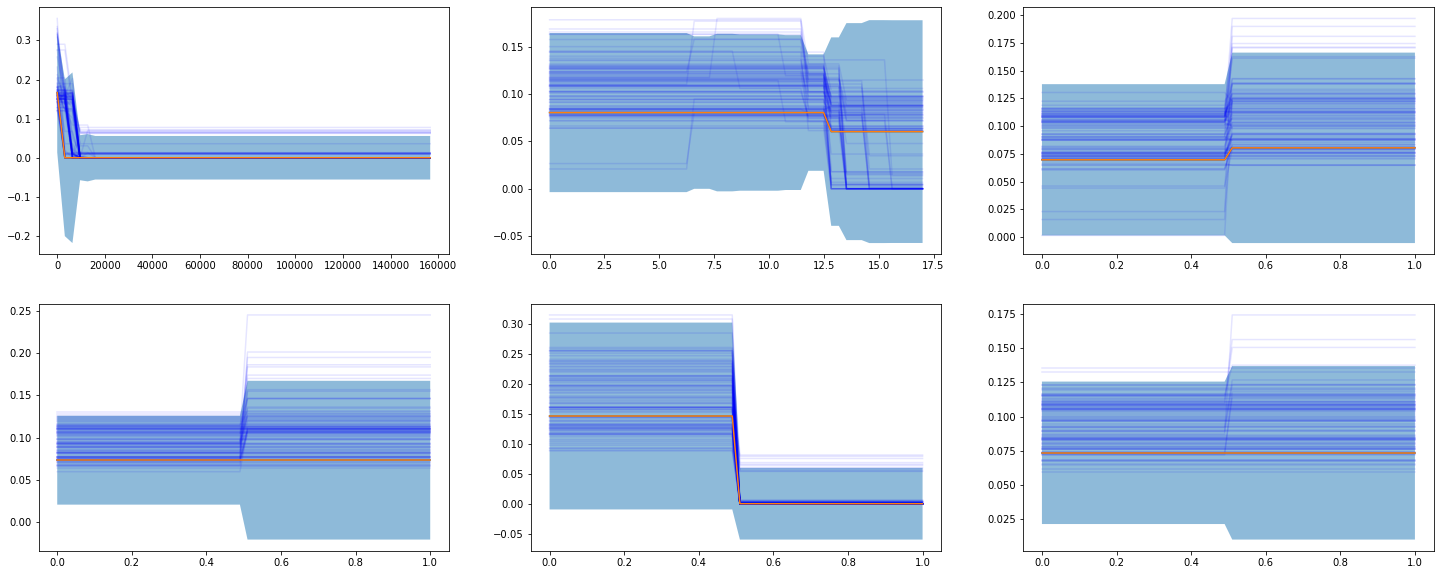

In [51]:
# CART
cart_explainer = TreeExplainer(tree.DecisionTreeClassifier,dataset2,cart_hyper_params2,covariates,target)
# Plot forest mdoels 
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(25,10))
plot1 = cart_explainer.bootstrapped_partial_plot(ax[0,0],tree.DecisionTreeClassifier,"treat","re75",100)
plot2 = cart_explainer.bootstrapped_partial_plot(ax[0,1],tree.DecisionTreeClassifier,"treat","education*",100)
plot3 = cart_explainer.bootstrapped_partial_plot(ax[0,2],tree.DecisionTreeClassifier,"treat","black",100)
plot4 = cart_explainer.bootstrapped_partial_plot(ax[1,0],tree.DecisionTreeClassifier,"treat","hispanic",100)
plot5 = cart_explainer.bootstrapped_partial_plot(ax[1,1],tree.DecisionTreeClassifier,"treat","married",100)
plot6 = cart_explainer.bootstrapped_partial_plot(ax[1,2],tree.DecisionTreeClassifier,"treat","nodegree",100)

plt.show()

In [ ]:
# Random forest
boost_explainer = TreeExplainer(XGBClassifier,dataset2,boost_hyper_params1,covariates,target)

# Plot forest mdoels 

fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(25,10))
plot1 = boost_explainer.bootstrapped_partial_plot(ax[0,0],XGBClassifier,"treat","re75")
plot2 = boost_explainer.bootstrapped_partial_plot(ax[0,1],XGBClassifier,"treat","education*")
plot3 = boost_explainer.bootstrapped_partial_plot(ax[0,2],XGBClassifier,"treat","black")
plot4 = boost_explainer.bootstrapped_partial_plot(ax[1,0],XGBClassifier,"treat","hispanic")
plot5 = boost_explainer.bootstrapped_partial_plot(ax[1,1],XGBClassifier,"treat","married")
plot6 = boost_explainer.bootstrapped_partial_plot(ax[1,2],XGBClassifier,"treat","nodegree")

plt.show()

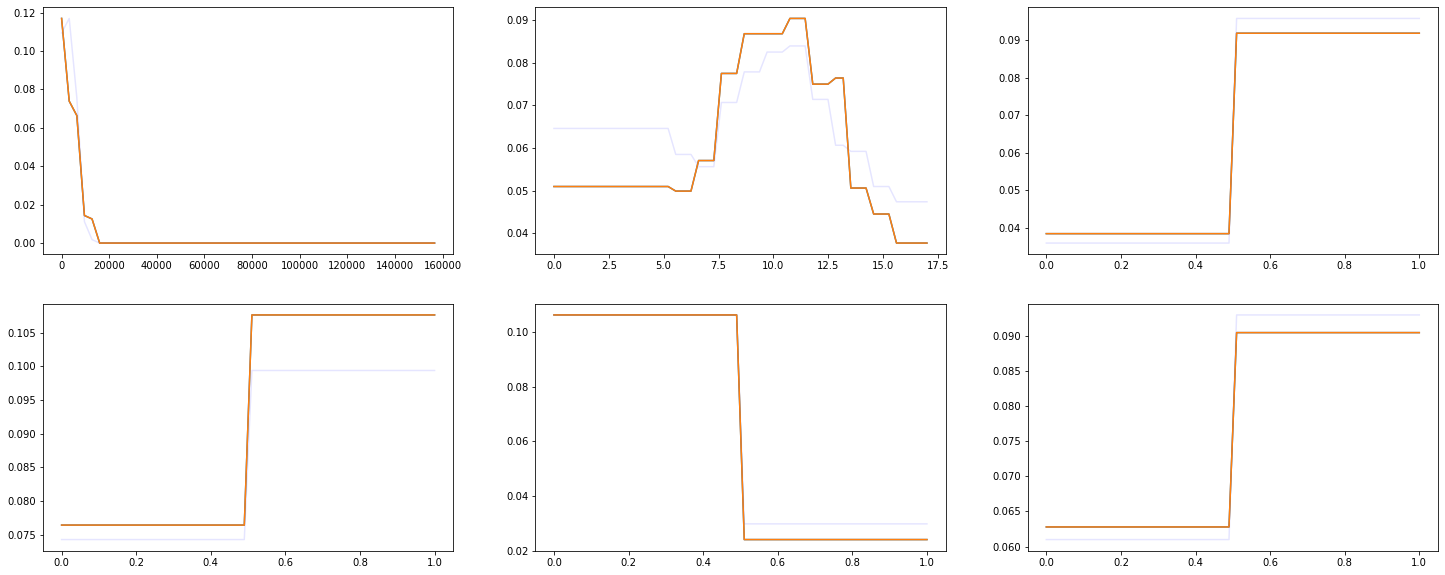

In [39]:
# Boosted tree 
boost_explainer = TreeExplainer(XGBClassifier,dataset2,boost_hyper_params1,covariates,target)
# Plot forest mdoels 
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(25,10))
plot1 = boost_explainer.bootstrapped_partial_plot(ax[0,0],XGBClassifier,"treat","re75",100)
plot2 = boost_explainer.bootstrapped_partial_plot(ax[0,1],XGBClassifier,"treat","education*",100)
plot3 = boost_explainer.bootstrapped_partial_plot(ax[0,2],XGBClassifier,"treat","black",100)
plot4 = boost_explainer.bootstrapped_partial_plot(ax[1,0],XGBClassifier,"treat","hispanic",100)
plot5 = boost_explainer.bootstrapped_partial_plot(ax[1,1],XGBClassifier,"treat","married",100)
plot6 = boost_explainer.bootstrapped_partial_plot(ax[1,2],XGBClassifier,"treat","nodegree",100)
plt.show()

# Plot tree
<p> read decision tree's </p>
<p> Leaves with children show their splitting criterion on the top  </p>
<p> The pair of values at the bottom show the count of False values and True values for the target respectively, of data points in that node of the tree.</p>

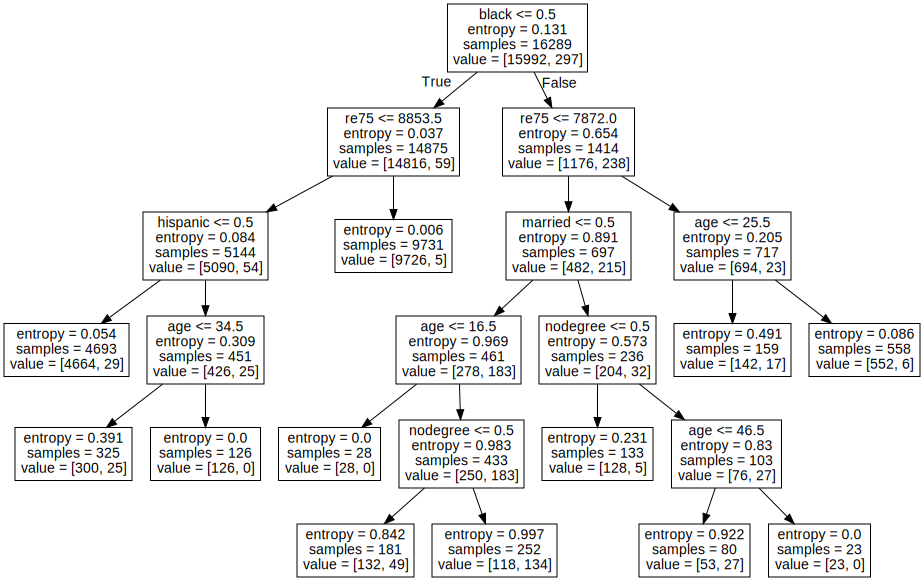

In [26]:
from sklearn import tree
import graphviz
tree_graph = tree.export_graphviz(tree1, out_file=None, feature_names=covariateSelection2)
graphviz.Source(tree_graph)

In [ ]:
#pdp.cart_graph(ax[0,0])
tree_graph
# Two jobs getting the DATA and 
# fitting the model 
# plot 

In [27]:
# 1 - Load in the data 
nswre74 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/NswDeWab_transformed.csv') # RCT 

In [34]:

tree1 = fit_data(tree.DecisionTreeClassifier,cart_hyper_params1,features_target_dictionary,nsw,"none")
data = nsw
tree1
tree.export_graphviz(tree1, out_file=None, feature_names=covariateSelection2)

<module 'sklearn.tree' from '/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/__init__.py'>

# Shapley values

 # Plotting shapley values for models